# 역전파

역전파를 수행하면 최종적으로 나온 오류를 다시 뒤로 전달해야 한다. 그 과정을 코드로 나타내보자.

In [8]:
import numpy as np


# 시그모이드
def sigmoid(x):
    return 1/(1+np.exp(-x))


# 시그모이드 기울기
def sigmoid_prime(x): 
    return sigmoid(x) * (1-sigmoid(x))


# 입력값과 레이블, 변수를 정의한다.
input1 = np.array([0.1, 0.3])
weights = np.array([0.4, -0.2])
hidden_weight = 0.1
true_y = 1

# 포워드 패스
l1 = sigmoid(np.dot(input1, weights))
l2 = sigmoid(np.dot(l1, hidden_weight))
pred_y = l2

# 오차와 에러텀 계산
error = abs(true_y - l2)
output_error_term = error * sigmoid_prime(np.dot(l1, hidden_weight))
hidden_error_term = output_error_term * hidden_weight * sigmoid_prime(np.dot(input1, weights))

# 업데이트할 w를 계산
learning_rate = 0.5
del_w_output = learning_rate * output_error_term * l1 # 출력층에서는 l1의 결과가 입력값이 된다.
del_w_hidden = learning_rate * hidden_error_term * input1

# 업데이트 수행
hidden_weight -= del_w_output
weights -= del_w_hidden

print(f'''\
pred_y: {l2}
error: {error}
output_error_term: {output_error_term}
hidden_error_term: {hidden_error_term}
del_w_output: {del_w_output}
del_w_hidden: {del_w_hidden}
l2_weights: {hidden_weight}
l1_weights: {weights}
''')

pred_y: 0.512372477962617
error: 0.487627522037383
output_error_term: 0.1218322353606694
hidden_error_term: 0.003045501323732555
del_w_output: 0.030153488404045865
del_w_hidden: [0.00015228 0.00045683]
l2_weights: 0.06984651159595415
l1_weights: [ 0.39984772 -0.20045683]



# 넘파이를 활용한 딥러닝 네트워크 구현

In [20]:
# 필요한 라이브러리 임포트
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

mnist = tf.keras.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 성능 이슈로 시그모이드가 아닌 relu 함수를 사용한다.
def relu(x):
    return np.maximum(0, x)


# 렐루의 미분 함수
def relu2deriv(output): 
    return output >= 0 


# 소프트맥스 함수
def softmax(a):
    # x를 그대로 전달하는 것이 아니라 각 값에서 최대 값을 차감
    x = a - np.max(a) #의 값은 기존보다 훨씬 작은 값이 안정화됨
    f_y = np.exp(x) / np.sum(np.exp(x)) # 오리지날 softmax 함수
    return f_y

def crossEntropyError(s, l):
    delta = 1e-10
    return -np.sum(l*np.log(s+delta))


# mnist 데이터셋의 전치리 수행
training_sample, test_sample = 10000, 1000
training_images = (x_train[0:training_sample]/255).reshape(-1, 784)
test_images = (x_test[0:test_sample]/255).reshape(-1, 784)

# y 레이블에 대한 원핫인코딩 수행
number_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ohe_y = OneHotEncoder(categories=[number_list], handle_unknown='ignore')
ohe_y.fit(t_train.reshape(-1,1))
training_labels  = ohe_y.transform(t_train.reshape(-1,1)).toarray()[:training_sample]
test_labels = ohe_y.transform(t_test.reshape(-1,1)).toarray()[:test_sample]

# 랜덤 시드
seed = 884736743
rng = np.random.default_rng(seed)

# 레이어에 필요한 변수 설정
learning_rate= 0.0005
epochs = 20
hidden_size= 100       # 히든 계층의 노드 개수
pixels_per_image = 784 # 입력 계층의 노드 개수
num_labels = 10

# 각 레이어에 필요한 가중치 설정
weights_1 = 0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1 # 784x100
weights_2 = 0.2 * rng.random((hidden_size, num_labels)) - 0.1       # 100x10

# 학습 진행 현황을 기록할 저장소
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# 루프 시작
for j in range(epochs):
    training_loss = 0.0
    training_accurate_predictions = 0
    
    for i in range(len(training_images)):
        # 포워드 패스
        layer_0 = training_images[i] # input
        layer_1 = relu(np.dot(layer_0, weights_1)) # l1
        layer_2 = softmax(np.dot(layer_1, weights_2)) # l2
        
        # 업데이트를 위해 오차 계산
        layer_2_delta = training_labels[i] - layer_2 # 마지막 레이어의 Loss
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1) # 한 레이어 전의 오류 계산
        
        # 변화할 가중치를 원래 가중치에 더함
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)
        
    # 한번의 에포치가 종료될 때마다 평가 결과를 측정한다.
    results = relu(test_images @ weights_1) @ weights_2
    test_loss = np.sum((test_labels - results) ** 2 )/test_sample # MSE
    #test_loss = crossEntropyError(test_labels, results)
    test_accurate_predictions = np.sum(np.argmax(results, axis=1) == np.argmax(test_labels, axis=1))/test_sample
    
    # 한번의 에포치가 종료될 때마다 훈련 결과를 측정한다.
    results = relu(training_images @ weights_1) @ weights_2
    training_loss = np.sum((training_labels - results) ** 2 )/training_sample # MSE
    #training_loss = crossEntropyError(training_labels, results)
    training_accurate_predictions = np.sum(np.argmax(results, axis=1) == np.argmax(training_labels, axis=1))/training_sample
    
    # 이번 에포치의 결과를 저장한다.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)
    
    # 이벤 에포치의 결과를 프린트
    print(f'''\
Epoch: {j} Training set error: {training_loss :.3f} \
Traing set accuracy: {training_accurate_predictions:.3f} \
Test set error: {test_loss:.3f} \
Test set accuracy: {test_accurate_predictions:.3f} \
''')        

Epoch: 0 Training set error: 11.395 Traing set accuracy: 0.798 Test set error: 10.021 Test set accuracy: 0.758 
Epoch: 1 Training set error: 35.897 Traing set accuracy: 0.853 Test set error: 31.514 Test set accuracy: 0.822 
Epoch: 2 Training set error: 55.185 Traing set accuracy: 0.874 Test set error: 48.524 Test set accuracy: 0.852 
Epoch: 3 Training set error: 69.441 Traing set accuracy: 0.886 Test set error: 61.179 Test set accuracy: 0.865 
Epoch: 4 Training set error: 80.297 Traing set accuracy: 0.893 Test set error: 70.881 Test set accuracy: 0.869 
Epoch: 5 Training set error: 88.852 Traing set accuracy: 0.899 Test set error: 78.570 Test set accuracy: 0.877 
Epoch: 6 Training set error: 95.812 Traing set accuracy: 0.903 Test set error: 84.852 Test set accuracy: 0.882 
Epoch: 7 Training set error: 101.633 Traing set accuracy: 0.906 Test set error: 90.124 Test set accuracy: 0.881 
Epoch: 8 Training set error: 106.615 Traing set accuracy: 0.911 Test set error: 94.647 Test set accurac

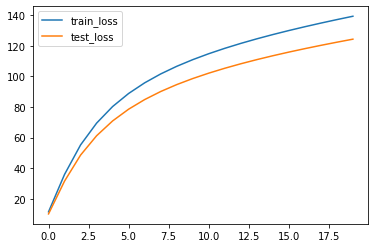

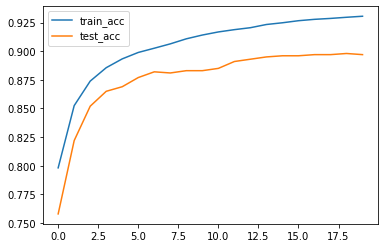

In [21]:
import pandas as pd

loss_history = pd.DataFrame([store_training_loss, store_test_loss], 
                            index = ['train_loss', 'test_loss'])
acc_history = pd.DataFrame([store_training_accurate_pred, store_test_accurate_pred], 
                            index = ['train_acc', 'test_acc'])

loss_history.T.plot()
plt.show()
acc_history.T.plot()
plt.show()

In [22]:
training_labels - results

array([[ -0.74585213,   4.00679801,  -0.98540445, ...,   0.9546216 ,
          0.45658857,   0.56678775],
       [-10.73506536,   8.75945807,  -2.08968251, ...,   1.01093245,
          1.48458616,   1.2348469 ],
       [  2.26906286,   3.78354002,  -1.38930672, ...,  -1.03139542,
          2.07466807,  -1.04340313],
       ...,
       [  2.73191298,   0.02201659,  -3.52590882, ...,   4.42901962,
         -1.84432664,   3.46956637],
       [  4.1110435 ,   3.19836631,   2.18310215, ...,  -1.73539641,
         -1.1276797 ,  -5.33742366],
       [  1.80312601,   3.9414188 ,   1.29782437, ...,  -6.84159483,
          1.32959602,  -5.13547644]])

In [23]:
results

array([[ 0.74585213, -4.00679801,  0.98540445, ..., -0.9546216 ,
        -0.45658857, -0.56678775],
       [11.73506536, -8.75945807,  2.08968251, ..., -1.01093245,
        -1.48458616, -1.2348469 ],
       [-2.26906286, -3.78354002,  1.38930672, ...,  1.03139542,
        -2.07466807,  1.04340313],
       ...,
       [-2.73191298, -0.02201659,  3.52590882, ..., -4.42901962,
         1.84432664, -3.46956637],
       [-4.1110435 , -3.19836631, -2.18310215, ...,  1.73539641,
         1.1276797 ,  6.33742366],
       [-1.80312601, -3.9414188 , -1.29782437, ...,  7.84159483,
        -1.32959602,  5.13547644]])